In [ ]:
from model import RNAseqClassifier, get_model_and_optimizer
from dataset import scRNAseqDataset
from train import train_model
import torch
import numpy as np
import torch.utils.data as data
from sklearn.model_selection import train_test_split
import anndata as ad
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import os
from get_api_keys import get_secret

In [3]:
from tqdm import tqdm
from clearml import Logger
import clearml
from clearml import Task

In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
os.environ["CLEARML_API_ACCESS_KEY"] = get_secret("CLEARML_API_ACCESS_KEY")
os.environ["CLEARML_API_SECRET_KEY"] = get_secret("CLEARML_API_SECRET_KEY")

clearml.browser_login()

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=XXQMNQA0L2KFEQ543XAX5I84ZUPS6Q
env: CLEARML_API_SECRET_KEY=BQtU7Xi6tuKz7ypMjSijeX8l2NmcP6ZWtcVdOJREAfhI7cEZL1SyT94lL585_Vy9M5Y


In [ ]:
adata_4369 = ad.read_h5ad('DATA/ANNDATAS/adata_scanvi_4369.h5ad')
adata_raw_4488 = ad.read_h5ad('DATA/ANNDATAS/adata_4488(all)_hvg.h5ad')

In [6]:
cells = adata_4369.obs_names
y = adata_4369.obs['Cluster'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)

cells_train, cells_temp, y_train, y_temp = train_test_split(
    cells, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

cells_val, cells_test, y_val, y_test = train_test_split(
    cells_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)

In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 15
LR_BASE = 0.0001
LR_SCANVI = 0.007

In [8]:
X_train = adata_raw_4488[cells_train].X
X_val = adata_raw_4488[cells_val].X
X_test = adata_raw_4488[cells_test].X

train_dataset = scRNAseqDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = scRNAseqDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_dataset = scRNAseqDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=128, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [14]:
X_train_scanvi = adata_4369[cells_train].obsm['X_scANVI']
X_val_scanvi = adata_4369[cells_val].obsm['X_scANVI']
X_test_scanvi = adata_4369[cells_test].obsm['X_scANVI']

train_dataset_scanvi = scRNAseqDataset(torch.from_numpy(X_train_scanvi), torch.from_numpy(y_train))
val_dataset_scanvi = scRNAseqDataset(torch.from_numpy(X_val_scanvi), torch.from_numpy(y_val))
test_dataset_scanvi = scRNAseqDataset(torch.from_numpy(X_test_scanvi), torch.from_numpy(y_test))

train_loader_scanvi = data.DataLoader(train_dataset_scanvi, batch_size=128, shuffle=True)
val_loader_scanvi = data.DataLoader(val_dataset_scanvi, batch_size=128, shuffle=True)
test_loader_scanvi = data.DataLoader(test_dataset_scanvi, batch_size=128, shuffle=False)

In [15]:
model_scanvi, optimizer_scanvi = get_model_and_optimizer(
    input_size=X_train_scanvi.shape[1],
    output_size=len(np.unique(y_train)),
    layer_config=None,
    lr=LR_SCANVI,
    weight_decay=0.00001
)

In [16]:
model, optimizer = get_model_and_optimizer(
    input_size=X_train.shape[1],
    output_size=len(np.unique(y_train)),
    layer_config=None,
    lr=LR_BASE,
    weight_decay=0.00001
)

In [17]:
torch.manual_seed(111)

task = Task.init(project_name='Modelling', task_name=f'SCANVI_FINAL')

train_model(
    model=model_scanvi,
    model_name="",
    train_loader=train_loader_scanvi,
    val_loader=val_loader_scanvi,
    optimizer=optimizer_scanvi,
    num_epochs=NUM_EPOCHS,
    device=DEVICE,
    task=task
)

task.close()

Could not read Jupyter Notebook: No module named 'nbconvert'


ClearML Task: created new task id=4b8c9c484d294324bfe24175f5772335


Please install nbconvert using "pip install nbconvert"


ClearML results page: https://app.clear.ml/projects/e7ad8385c3454c3f88f0353baedffffb/experiments/4b8c9c484d294324bfe24175f5772335/output/log


Initial Validation: 100%|██████████| 121/121 [00:01<00:00, 97.31it/s]
 | Epoch 1/15 [Train]: 100%|██████████| 422/422 [00:03<00:00, 117.65it/s]
Epoch 1/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 817.83it/s]


Epoch 1/15 | Train Acc: 0.9207 | Val Acc: 0.9772 | Train F1: 0.8098 | Val F1: 0.9360


 | Epoch 2/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 270.68it/s]
Epoch 2/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 712.24it/s]


Epoch 2/15 | Train Acc: 0.9511 | Val Acc: 0.9808 | Train F1: 0.8947 | Val F1: 0.9531


 | Epoch 3/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 298.42it/s]
Epoch 3/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 904.75it/s]


Epoch 3/15 | Train Acc: 0.9566 | Val Acc: 0.9822 | Train F1: 0.9082 | Val F1: 0.9649


 | Epoch 4/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 319.65it/s]
Epoch 4/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 974.60it/s] 


Epoch 4/15 | Train Acc: 0.9599 | Val Acc: 0.9815 | Train F1: 0.9287 | Val F1: 0.9616


 | Epoch 5/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 372.17it/s]
Epoch 5/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1019.93it/s]


Epoch 5/15 | Train Acc: 0.9632 | Val Acc: 0.9824 | Train F1: 0.9315 | Val F1: 0.9731


 | Epoch 6/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 338.65it/s]
Epoch 6/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 978.96it/s]


Epoch 6/15 | Train Acc: 0.9638 | Val Acc: 0.9834 | Train F1: 0.9319 | Val F1: 0.9652


 | Epoch 7/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 319.68it/s]
Epoch 7/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1013.33it/s]


Epoch 7/15 | Train Acc: 0.9633 | Val Acc: 0.9828 | Train F1: 0.9372 | Val F1: 0.9617


 | Epoch 8/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 318.77it/s]
Epoch 8/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1033.22it/s]


Epoch 8/15 | Train Acc: 0.9637 | Val Acc: 0.9826 | Train F1: 0.9358 | Val F1: 0.9647


 | Epoch 9/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 326.13it/s]
Epoch 9/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1036.38it/s]


Epoch 9/15 | Train Acc: 0.9646 | Val Acc: 0.9829 | Train F1: 0.9421 | Val F1: 0.9703


 | Epoch 10/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 361.01it/s]
Epoch 10/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 965.03it/s]


Epoch 10/15 | Train Acc: 0.9642 | Val Acc: 0.9836 | Train F1: 0.9397 | Val F1: 0.9677


 | Epoch 11/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 303.70it/s]
Epoch 11/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 894.96it/s]


Epoch 11/15 | Train Acc: 0.9649 | Val Acc: 0.9836 | Train F1: 0.9378 | Val F1: 0.9534


 | Epoch 12/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 338.80it/s]
Epoch 12/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1013.29it/s]


Epoch 12/15 | Train Acc: 0.9651 | Val Acc: 0.9834 | Train F1: 0.9371 | Val F1: 0.9657


 | Epoch 13/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 316.14it/s]
Epoch 13/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1017.49it/s]


Epoch 13/15 | Train Acc: 0.9646 | Val Acc: 0.9827 | Train F1: 0.9427 | Val F1: 0.9556


 | Epoch 14/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 328.63it/s]
Epoch 14/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 923.47it/s]


Epoch 14/15 | Train Acc: 0.9650 | Val Acc: 0.9841 | Train F1: 0.9456 | Val F1: 0.9665


 | Epoch 15/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 310.68it/s]
Epoch 15/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 1028.80it/s]


Epoch 15/15 | Train Acc: 0.9648 | Val Acc: 0.9829 | Train F1: 0.9362 | Val F1: 0.9618


In [24]:
torch.manual_seed(111)

task = Task.init(project_name='Modelling', task_name=f'RAW_MODEL_FINAL')

train_model(
    model=model,
    model_name="",
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    num_epochs=NUM_EPOCHS,
    device=DEVICE,
    task=task
)

task.close()

Could not read Jupyter Notebook: No module named 'nbconvert'
Please install nbconvert using "pip install nbconvert"


ClearML Task: created new task id=782f507c95d24e5f86d8408a1e3acea0
ClearML results page: https://app.clear.ml/projects/e7ad8385c3454c3f88f0353baedffffb/experiments/782f507c95d24e5f86d8408a1e3acea0/output/log


Initial Validation: 100%|██████████| 121/121 [00:00<00:00, 507.50it/s]
 | Epoch 1/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 244.32it/s]
Epoch 1/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 554.89it/s]


Epoch 1/15 | Train Acc: 0.5659 | Val Acc: 0.7663 | Train F1: 0.2718 | Val F1: 0.4419


 | Epoch 2/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 243.71it/s]
Epoch 2/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 606.92it/s]


Epoch 2/15 | Train Acc: 0.7752 | Val Acc: 0.8428 | Train F1: 0.4801 | Val F1: 0.6130


 | Epoch 3/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 248.33it/s]
Epoch 3/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 573.47it/s]


Epoch 3/15 | Train Acc: 0.8530 | Val Acc: 0.8730 | Train F1: 0.6473 | Val F1: 0.7311


 | Epoch 4/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 253.86it/s]
Epoch 4/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 593.27it/s]


Epoch 4/15 | Train Acc: 0.8948 | Val Acc: 0.8796 | Train F1: 0.7463 | Val F1: 0.7591


 | Epoch 5/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 246.62it/s]
Epoch 5/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 556.99it/s]


Epoch 5/15 | Train Acc: 0.9176 | Val Acc: 0.8770 | Train F1: 0.7750 | Val F1: 0.7605


 | Epoch 6/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 242.85it/s]
Epoch 6/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 588.29it/s]


Epoch 6/15 | Train Acc: 0.9325 | Val Acc: 0.8763 | Train F1: 0.7906 | Val F1: 0.7608


 | Epoch 7/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 238.95it/s]
Epoch 7/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 572.97it/s]


Epoch 7/15 | Train Acc: 0.9450 | Val Acc: 0.8746 | Train F1: 0.8023 | Val F1: 0.7603


 | Epoch 8/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 244.66it/s]
Epoch 8/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 613.20it/s]


Epoch 8/15 | Train Acc: 0.9549 | Val Acc: 0.8743 | Train F1: 0.8102 | Val F1: 0.7763


 | Epoch 9/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 230.61it/s]
Epoch 9/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 588.58it/s]


Epoch 9/15 | Train Acc: 0.9623 | Val Acc: 0.8728 | Train F1: 0.8449 | Val F1: 0.7887


 | Epoch 10/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 242.46it/s]
Epoch 10/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 605.54it/s]


Epoch 10/15 | Train Acc: 0.9681 | Val Acc: 0.8735 | Train F1: 0.8688 | Val F1: 0.8199


 | Epoch 11/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 255.01it/s]
Epoch 11/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 601.96it/s]


Epoch 11/15 | Train Acc: 0.9743 | Val Acc: 0.8731 | Train F1: 0.8989 | Val F1: 0.8303


 | Epoch 12/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 251.42it/s]
Epoch 12/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 591.73it/s]


Epoch 12/15 | Train Acc: 0.9776 | Val Acc: 0.8728 | Train F1: 0.9146 | Val F1: 0.8601


 | Epoch 13/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 246.44it/s]
Epoch 13/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 563.89it/s]


Epoch 13/15 | Train Acc: 0.9802 | Val Acc: 0.8702 | Train F1: 0.9484 | Val F1: 0.8708


 | Epoch 14/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 250.26it/s]
Epoch 14/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 591.51it/s]


Epoch 14/15 | Train Acc: 0.9844 | Val Acc: 0.8691 | Train F1: 0.9532 | Val F1: 0.8674


 | Epoch 15/15 [Train]: 100%|██████████| 422/422 [00:01<00:00, 239.36it/s]
Epoch 15/15 [Val]: 100%|██████████| 121/121 [00:00<00:00, 555.84it/s]


Epoch 15/15 | Train Acc: 0.9857 | Val Acc: 0.8703 | Train F1: 0.9646 | Val F1: 0.8705


In [29]:
def evaluate_model(model, test_loader, label_encoder, device):
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(labels.numpy())

    decoded_preds = label_encoder.inverse_transform(all_preds)
    decoded_targets = label_encoder.inverse_transform(all_targets)

    return decoded_targets, decoded_preds


In [30]:
decoded_targets, decoded_preds = evaluate_model(model, test_loader, le, DEVICE)
decoded_targets_scanvi, decoded_preds_scanvi = evaluate_model(model_scanvi, test_loader_scanvi, le, DEVICE)

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(decoded_targets, decoded_preds, label_encoder, title="Confusion Matrix (%)"):
    cm = confusion_matrix(decoded_targets, decoded_preds, labels=label_encoder.classes_)

    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.figure(figsize=(14, 10))
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

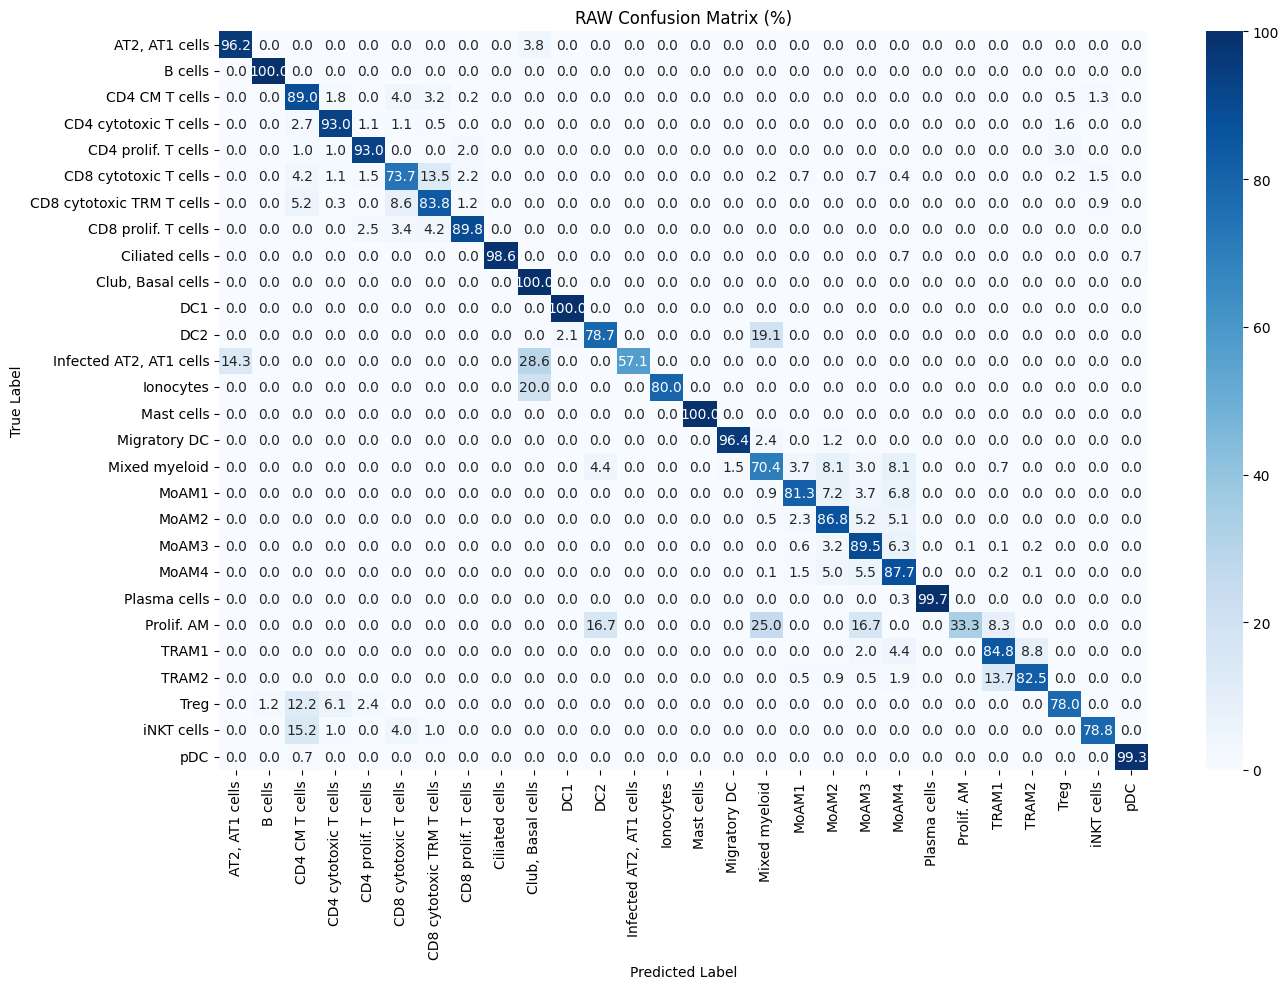

In [32]:
plot_confusion_matrix(decoded_targets, decoded_preds, le, title="RAW Confusion Matrix (%)")

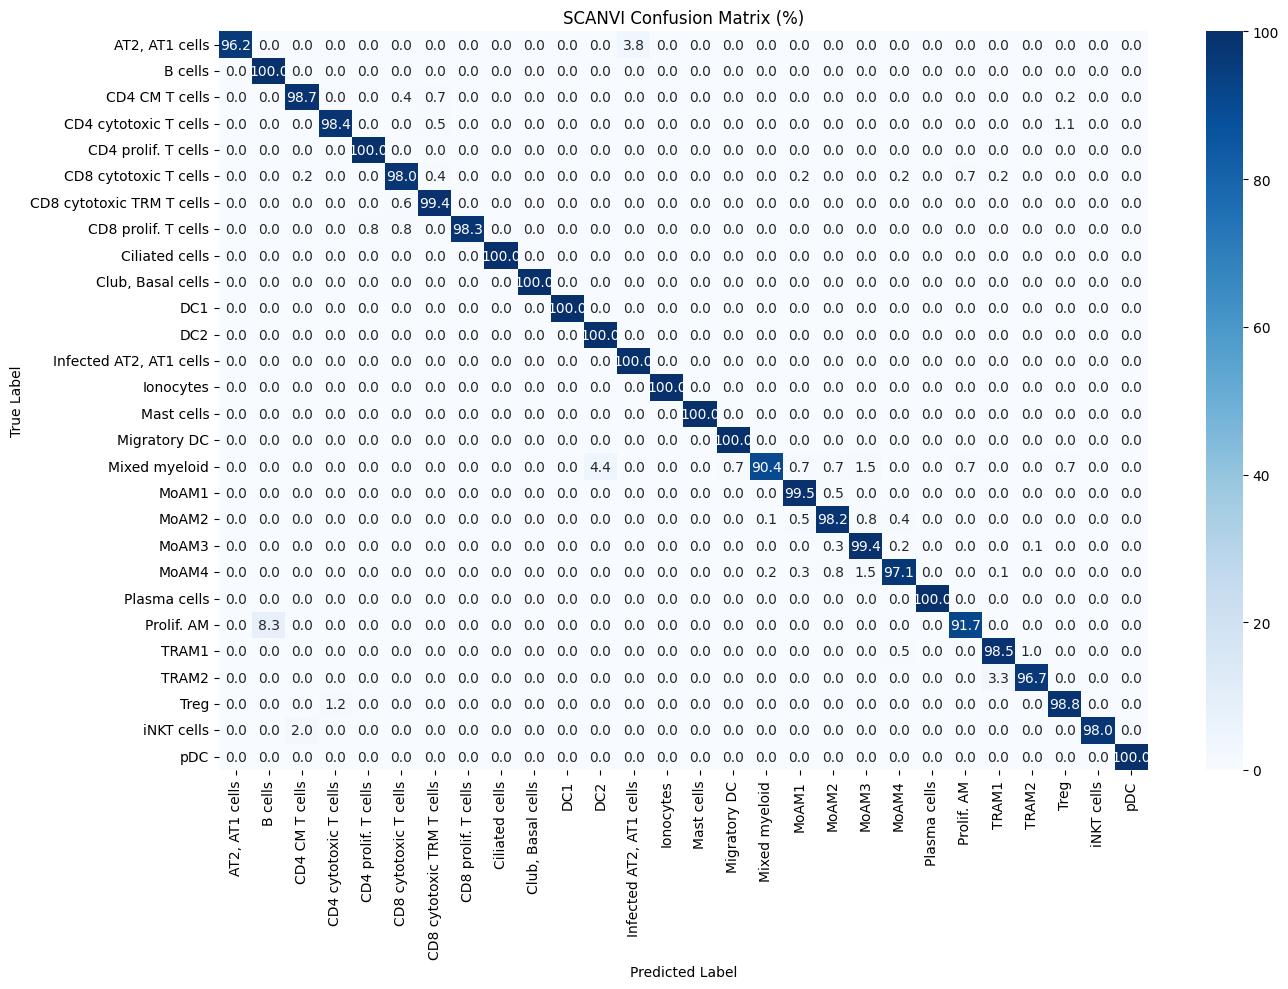

In [33]:
plot_confusion_matrix(decoded_targets_scanvi, decoded_preds_scanvi, le, title="SCANVI Confusion Matrix (%)")